In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 20

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -50
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 0  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10 #10
NEGATIVE_REWARD_DIVIDE = 1 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 1  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        
        self.learning_rate = 0.001
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


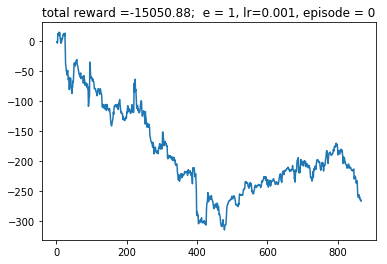

Waiting to train the whole dataset
action0:  699 
action1:  649 
action2:  632
DONE, lets roll!!
86.06


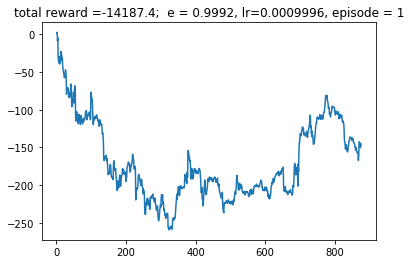

Waiting to train the whole dataset
action0:  701 
action1:  646 
action2:  633
DONE, lets roll!!
82.663


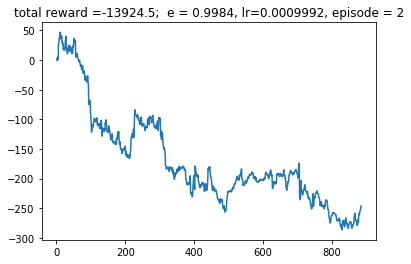

Waiting to train the whole dataset
action0:  673 
action1:  669 
action2:  638
DONE, lets roll!!
80.163


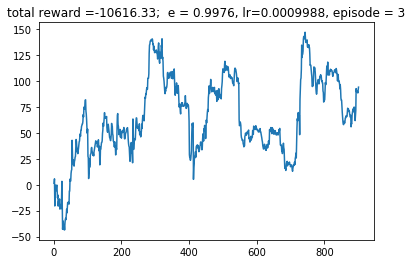

Waiting to train the whole dataset
action0:  651 
action1:  661 
action2:  668
DONE, lets roll!!
71.52


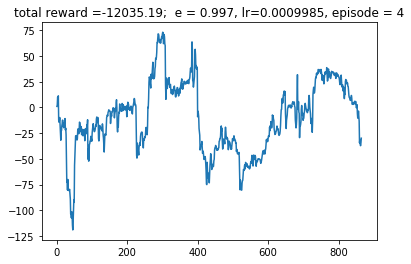

Waiting to train the whole dataset
action0:  654 
action1:  640 
action2:  686
DONE, lets roll!!
71.195


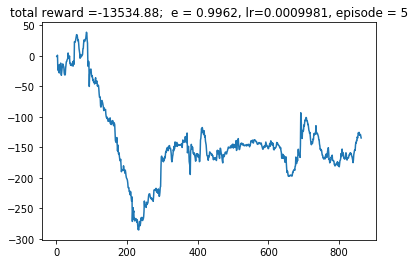

Waiting to train the whole dataset
action0:  670 
action1:  655 
action2:  655
DONE, lets roll!!
70.704


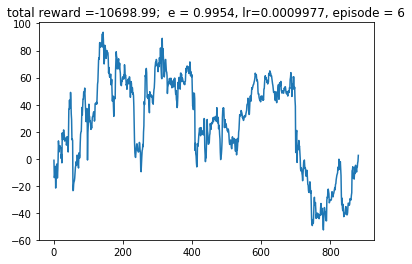

Waiting to train the whole dataset
action0:  660 
action1:  655 
action2:  665
DONE, lets roll!!
69.898


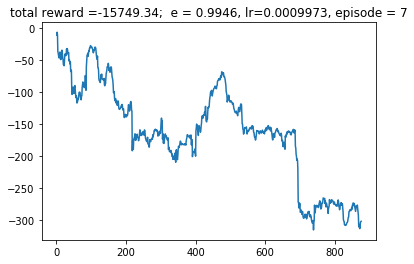

Waiting to train the whole dataset
action0:  707 
action1:  645 
action2:  628
DONE, lets roll!!
70.254


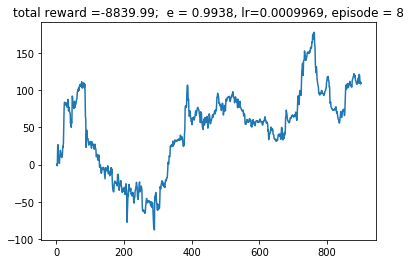

Waiting to train the whole dataset
action0:  637 
action1:  649 
action2:  694
DONE, lets roll!!
70.077


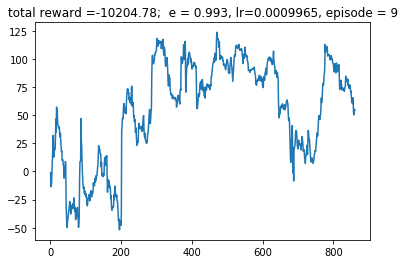

Waiting to train the whole dataset
action0:  633 
action1:  649 
action2:  698
DONE, lets roll!!
70.309


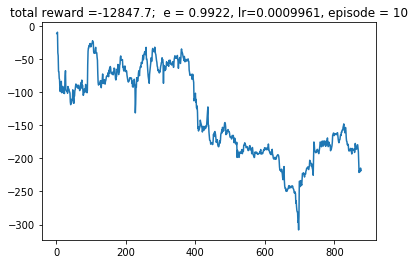

Waiting to train the whole dataset
action0:  637 
action1:  632 
action2:  711
DONE, lets roll!!
70.705


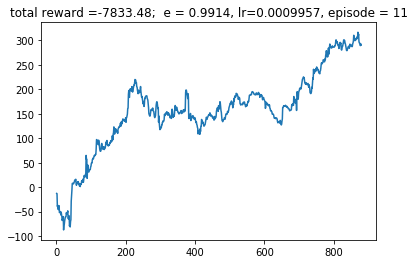

Waiting to train the whole dataset
action0:  654 
action1:  626 
action2:  700
DONE, lets roll!!
69.91


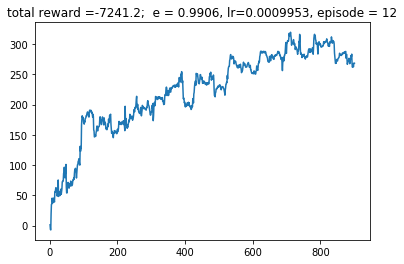

Waiting to train the whole dataset
action0:  620 
action1:  650 
action2:  710
DONE, lets roll!!
69.94


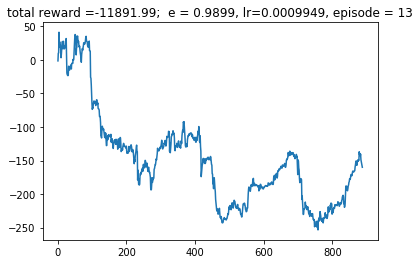

Waiting to train the whole dataset
action0:  641 
action1:  652 
action2:  687
DONE, lets roll!!
70.385


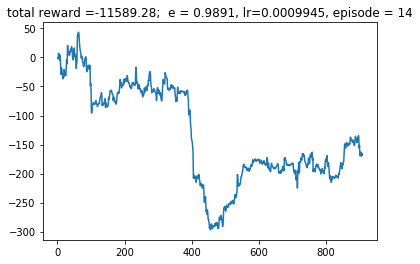

Waiting to train the whole dataset
action0:  628 
action1:  706 
action2:  646
DONE, lets roll!!
70.173


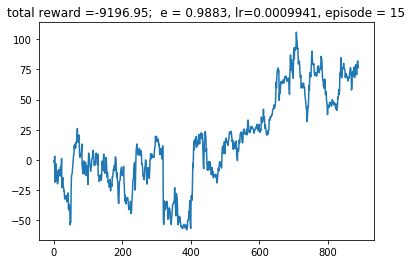

Waiting to train the whole dataset
action0:  646 
action1:  661 
action2:  673
DONE, lets roll!!
69.739


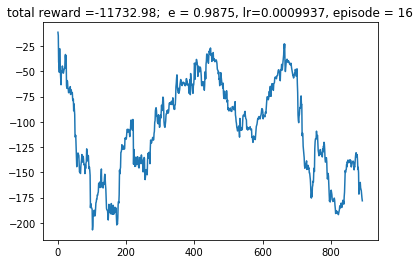

Waiting to train the whole dataset
action0:  621 
action1:  718 
action2:  641
DONE, lets roll!!
70.119


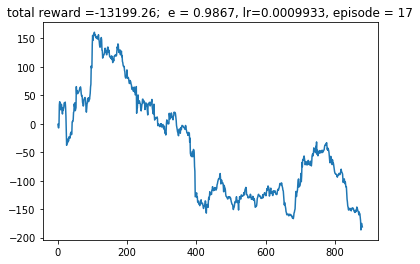

Waiting to train the whole dataset
action0:  672 
action1:  686 
action2:  622
DONE, lets roll!!
70.375


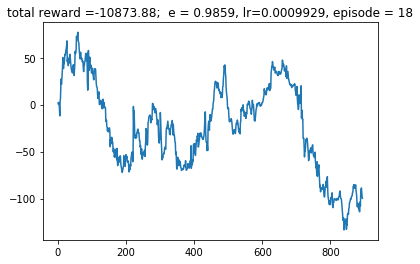

Waiting to train the whole dataset
action0:  624 
action1:  673 
action2:  683
DONE, lets roll!!
69.961


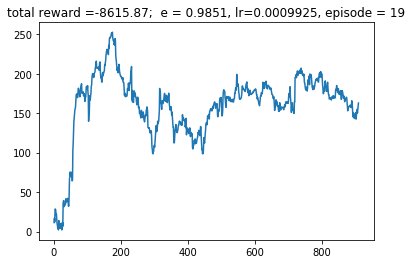

Waiting to train the whole dataset
action0:  634 
action1:  692 
action2:  654
DONE, lets roll!!
70.616


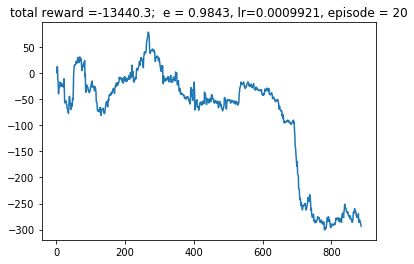

Waiting to train the whole dataset
action0:  638 
action1:  675 
action2:  667
DONE, lets roll!!
69.957


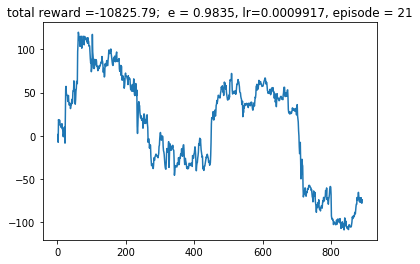

Waiting to train the whole dataset
action0:  619 
action1:  682 
action2:  679
DONE, lets roll!!
70.17


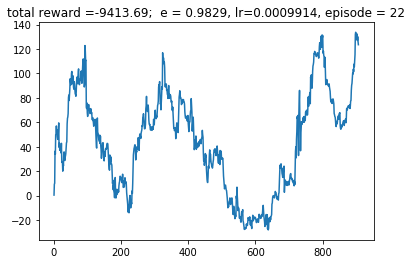

Waiting to train the whole dataset
action0:  661 
action1:  661 
action2:  658
DONE, lets roll!!
70.633


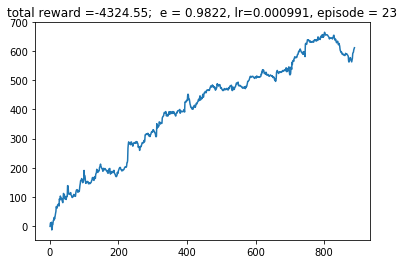

Waiting to train the whole dataset
action0:  660 
action1:  633 
action2:  687
DONE, lets roll!!
73.526


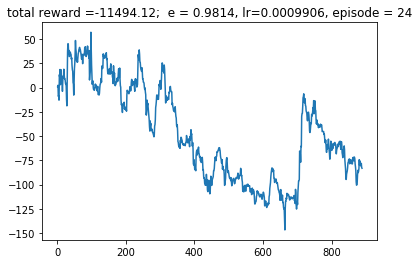

Waiting to train the whole dataset
action0:  652 
action1:  638 
action2:  690
DONE, lets roll!!
70.042


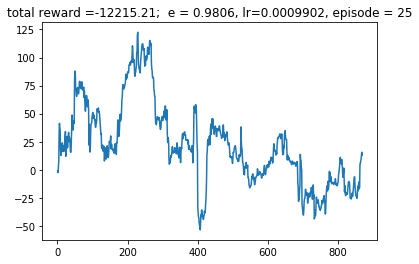

Waiting to train the whole dataset
action0:  659 
action1:  649 
action2:  672
DONE, lets roll!!
70.121


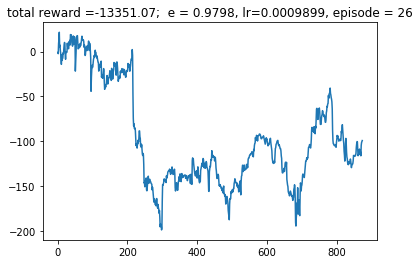

Waiting to train the whole dataset
action0:  674 
action1:  620 
action2:  686
DONE, lets roll!!
70.496


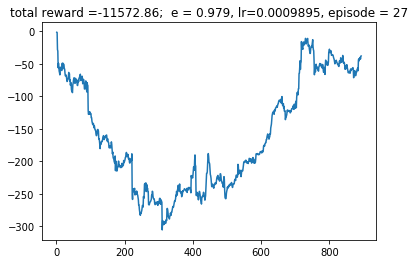

Waiting to train the whole dataset
action0:  667 
action1:  648 
action2:  665
DONE, lets roll!!
69.854


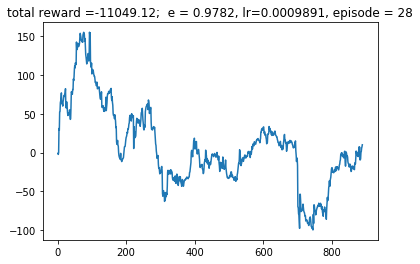

Waiting to train the whole dataset
action0:  666 
action1:  710 
action2:  604
DONE, lets roll!!
71.082


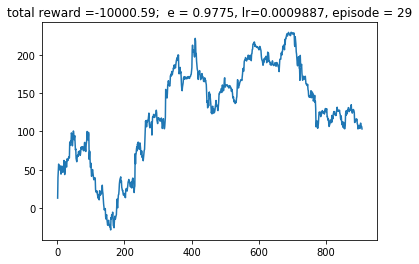

Waiting to train the whole dataset
action0:  631 
action1:  681 
action2:  668
DONE, lets roll!!
69.752


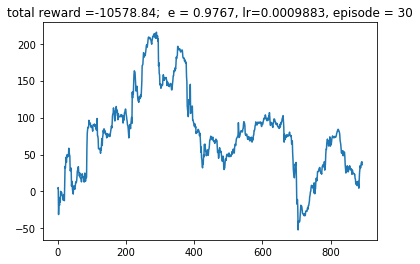

Waiting to train the whole dataset
action0:  652 
action1:  661 
action2:  667
DONE, lets roll!!
70.261


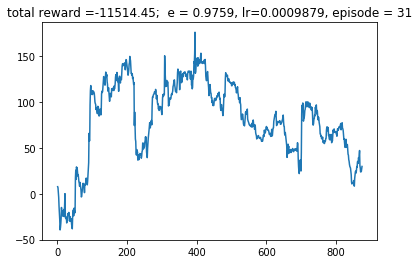

Waiting to train the whole dataset
action0:  657 
action1:  693 
action2:  630
DONE, lets roll!!
71.067


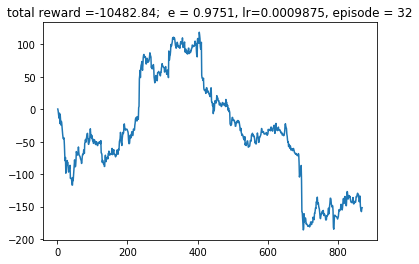

Waiting to train the whole dataset
action0:  605 
action1:  656 
action2:  719
DONE, lets roll!!
86.164


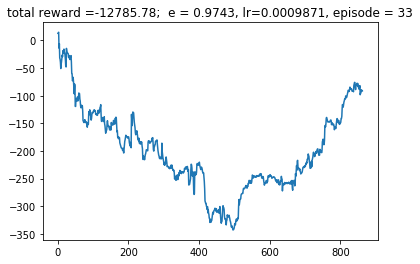

Waiting to train the whole dataset
action0:  659 
action1:  650 
action2:  671
DONE, lets roll!!
75.272


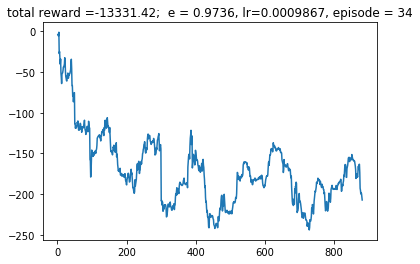

Waiting to train the whole dataset
action0:  681 
action1:  637 
action2:  662
DONE, lets roll!!
70.726


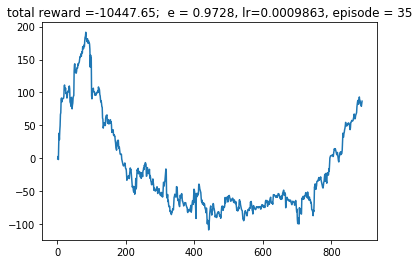

Waiting to train the whole dataset
action0:  675 
action1:  663 
action2:  642
DONE, lets roll!!
70.26


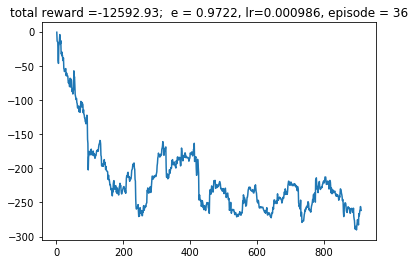

Waiting to train the whole dataset
action0:  620 
action1:  665 
action2:  695
DONE, lets roll!!
71.151


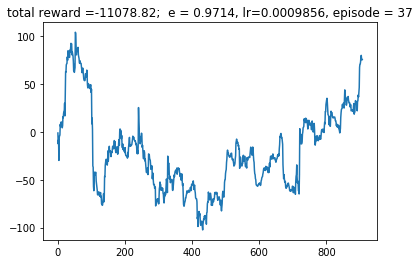

Waiting to train the whole dataset
action0:  672 
action1:  659 
action2:  649
DONE, lets roll!!
70.218


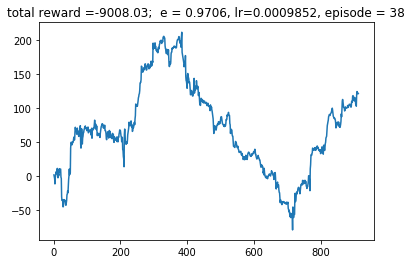

Waiting to train the whole dataset
action0:  636 
action1:  688 
action2:  656
DONE, lets roll!!
70.706


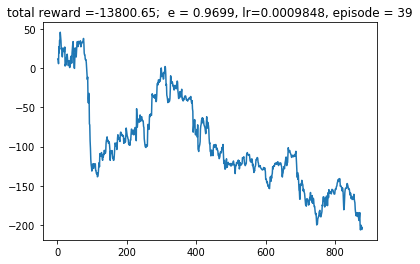

Waiting to train the whole dataset
action0:  656 
action1:  661 
action2:  663
DONE, lets roll!!
69.862


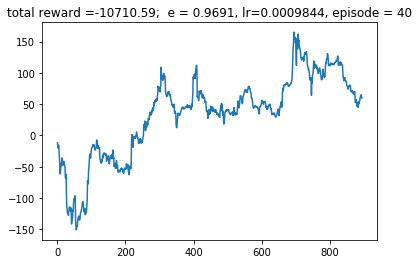

Waiting to train the whole dataset
action0:  659 
action1:  639 
action2:  682
DONE, lets roll!!
70.606


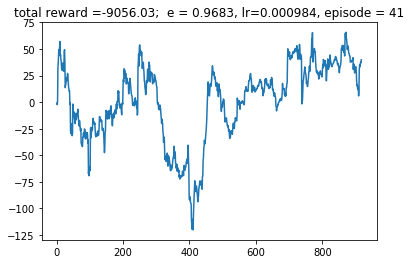

Waiting to train the whole dataset
action0:  616 
action1:  692 
action2:  672
DONE, lets roll!!
70.333


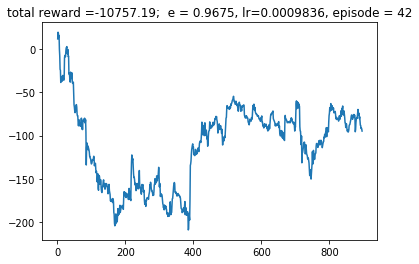

Waiting to train the whole dataset
action0:  637 
action1:  705 
action2:  638
DONE, lets roll!!
70.35


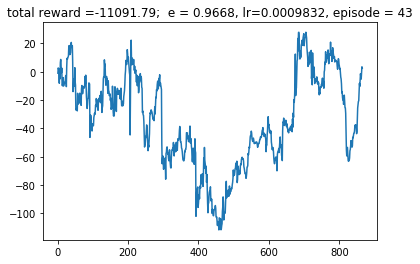

Waiting to train the whole dataset
action0:  658 
action1:  681 
action2:  641
DONE, lets roll!!
70.332


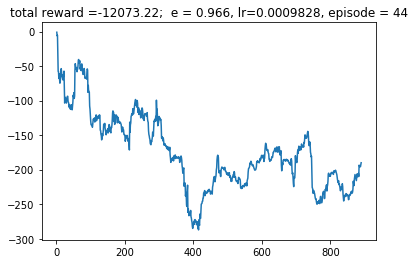

Waiting to train the whole dataset
action0:  626 
action1:  720 
action2:  634
DONE, lets roll!!
70.083


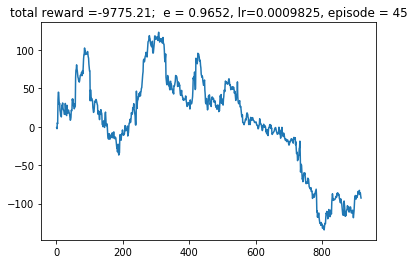

Waiting to train the whole dataset
action0:  609 
action1:  660 
action2:  711
DONE, lets roll!!
70.375


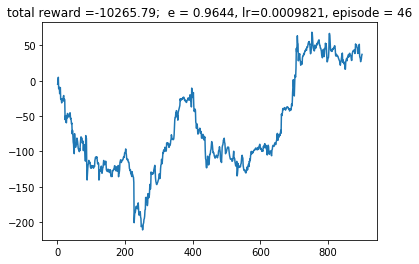

Waiting to train the whole dataset
action0:  634 
action1:  622 
action2:  724
DONE, lets roll!!
71.51


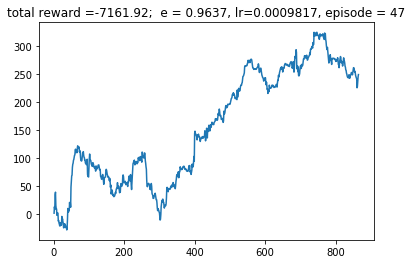

Waiting to train the whole dataset
action0:  618 
action1:  651 
action2:  711
DONE, lets roll!!
70.618


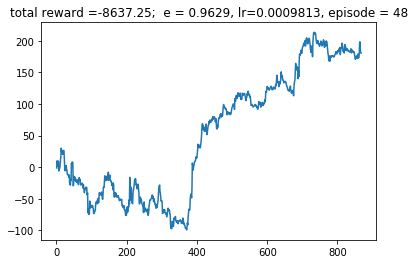

Waiting to train the whole dataset
action0:  648 
action1:  711 
action2:  621
DONE, lets roll!!
70.79


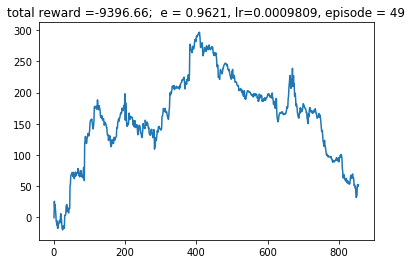

Waiting to train the whole dataset
action0:  618 
action1:  644 
action2:  718
DONE, lets roll!!
70.479


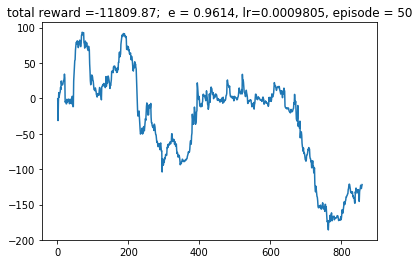

Waiting to train the whole dataset
action0:  633 
action1:  749 
action2:  598
DONE, lets roll!!
70.495


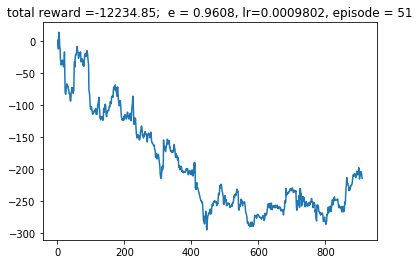

Waiting to train the whole dataset
action0:  628 
action1:  663 
action2:  689
DONE, lets roll!!
70.029


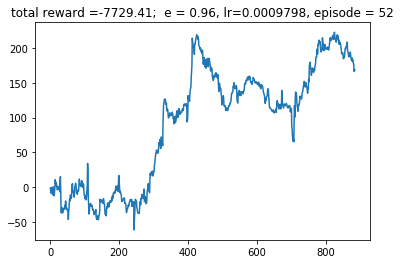

Waiting to train the whole dataset
action0:  603 
action1:  640 
action2:  737
DONE, lets roll!!
70.037


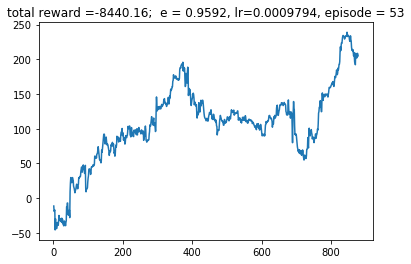

Waiting to train the whole dataset
action0:  654 
action1:  628 
action2:  698
DONE, lets roll!!
69.464


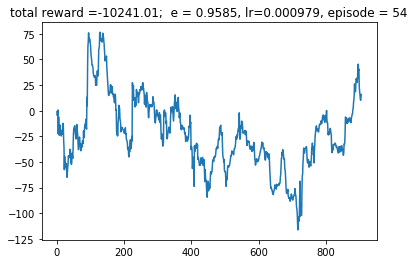

Waiting to train the whole dataset
action0:  625 
action1:  663 
action2:  692
DONE, lets roll!!
69.943


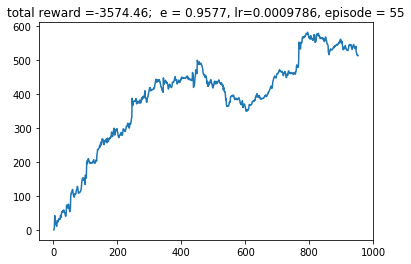

Waiting to train the whole dataset
action0:  593 
action1:  653 
action2:  734
DONE, lets roll!!
69.556


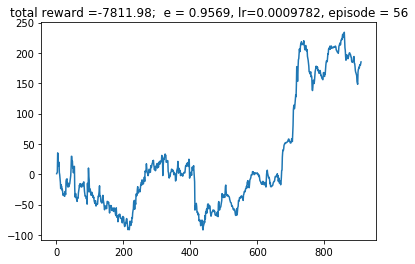

Waiting to train the whole dataset
action0:  611 
action1:  687 
action2:  682
DONE, lets roll!!
70.158


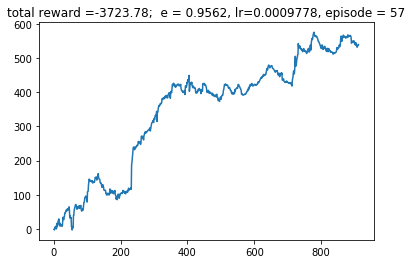

Waiting to train the whole dataset
action0:  622 
action1:  688 
action2:  670
DONE, lets roll!!
69.92


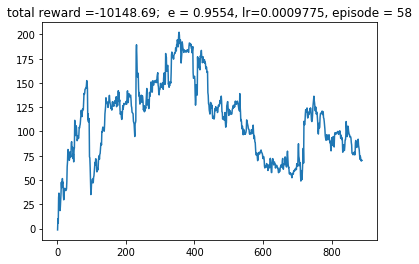

Waiting to train the whole dataset
action0:  652 
action1:  618 
action2:  710
DONE, lets roll!!
70.528


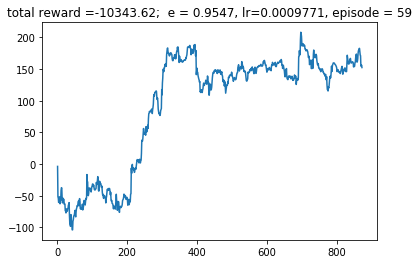

Waiting to train the whole dataset
action0:  666 
action1:  682 
action2:  632
DONE, lets roll!!
69.917


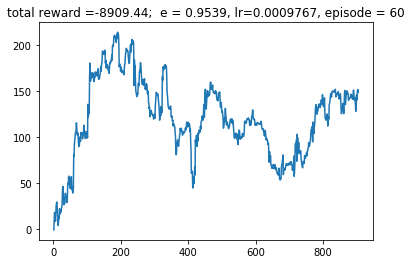

Waiting to train the whole dataset
action0:  632 
action1:  645 
action2:  703
DONE, lets roll!!
71.136


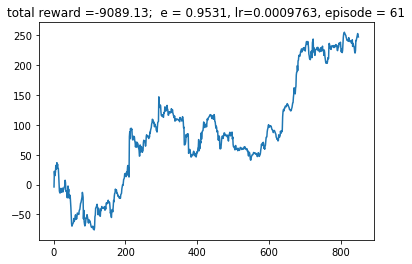

Waiting to train the whole dataset
action0:  664 
action1:  671 
action2:  645
DONE, lets roll!!
70.101


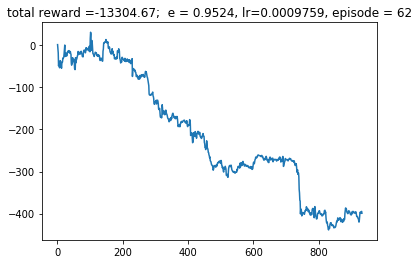

Waiting to train the whole dataset
action0:  627 
action1:  686 
action2:  667
DONE, lets roll!!
70.328


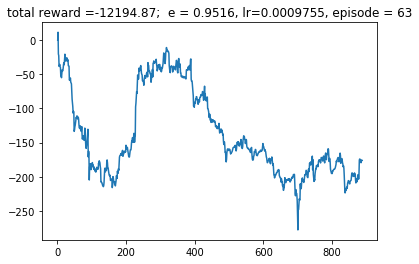

Waiting to train the whole dataset
action0:  608 
action1:  639 
action2:  733
DONE, lets roll!!
71.311


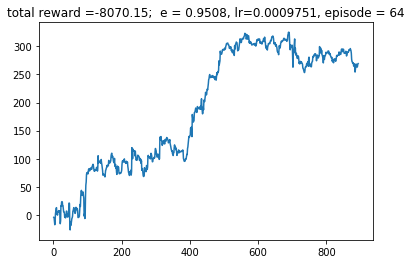

Waiting to train the whole dataset
action0:  648 
action1:  684 
action2:  648
DONE, lets roll!!
71.283


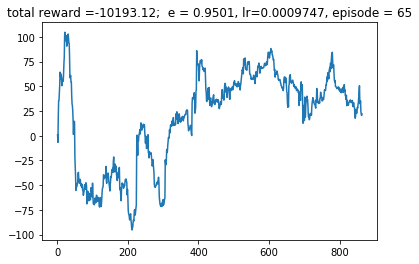

Waiting to train the whole dataset
action0:  607 
action1:  738 
action2:  635
DONE, lets roll!!
71.837


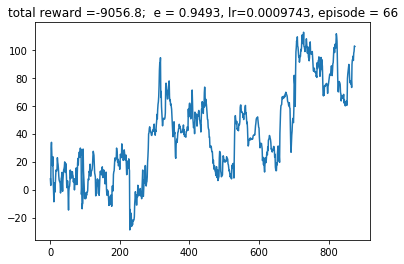

Waiting to train the whole dataset
action0:  628 
action1:  650 
action2:  702
DONE, lets roll!!
72.385


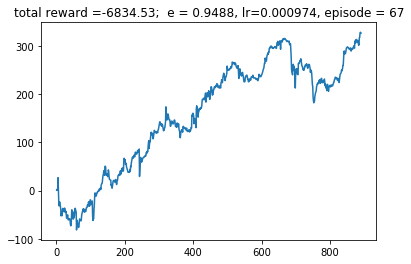

Waiting to train the whole dataset
action0:  632 
action1:  699 
action2:  649
DONE, lets roll!!
72.059


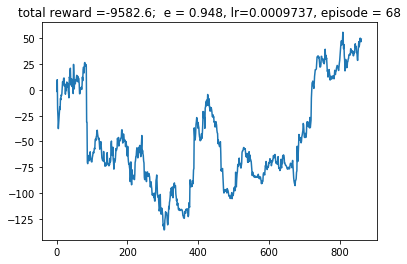

Waiting to train the whole dataset
action0:  639 
action1:  581 
action2:  760
DONE, lets roll!!
71.724


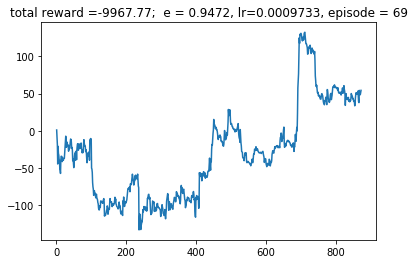

Waiting to train the whole dataset
action0:  638 
action1:  748 
action2:  594
DONE, lets roll!!
71.173


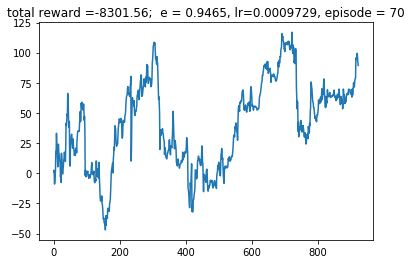

Waiting to train the whole dataset
action0:  614 
action1:  730 
action2:  636
DONE, lets roll!!
72.518


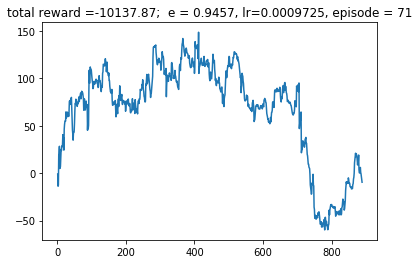

Waiting to train the whole dataset
action0:  618 
action1:  611 
action2:  751
DONE, lets roll!!
72.533


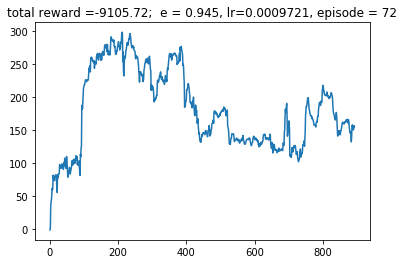

Waiting to train the whole dataset
action0:  609 
action1:  746 
action2:  625
DONE, lets roll!!
71.815


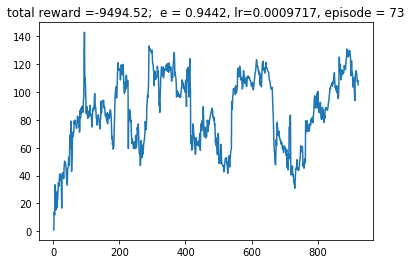

Waiting to train the whole dataset
action0:  639 
action1:  682 
action2:  659
DONE, lets roll!!
72.529


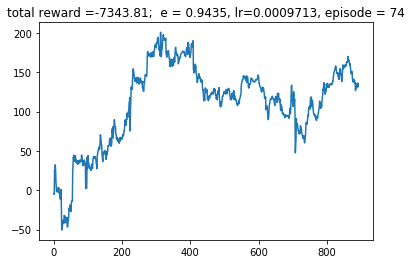

Waiting to train the whole dataset
action0:  607 
action1:  730 
action2:  643
DONE, lets roll!!
72.284


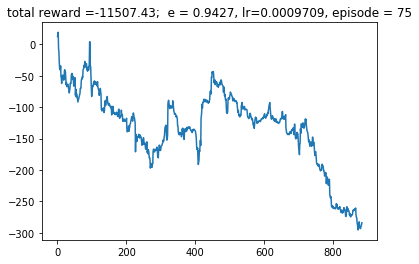

Waiting to train the whole dataset
action0:  595 
action1:  752 
action2:  633
DONE, lets roll!!
75.042


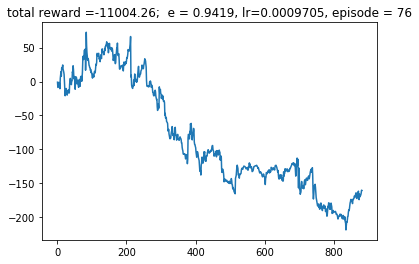

Waiting to train the whole dataset
action0:  606 
action1:  727 
action2:  647
DONE, lets roll!!
78.585


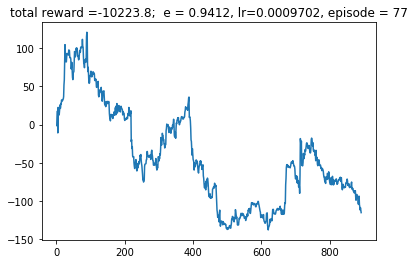

Waiting to train the whole dataset
action0:  600 
action1:  727 
action2:  653
DONE, lets roll!!
76.282


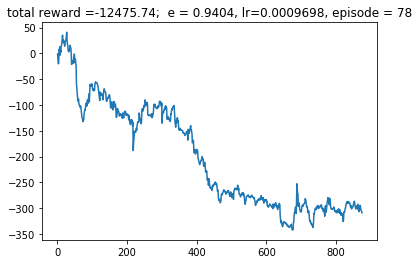

Waiting to train the whole dataset
action0:  575 
action1:  662 
action2:  743
DONE, lets roll!!
86.583


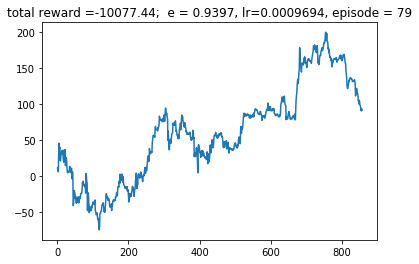

Waiting to train the whole dataset
action0:  658 
action1:  742 
action2:  580
DONE, lets roll!!
87.053


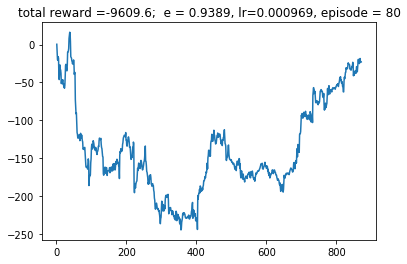

Waiting to train the whole dataset
action0:  598 
action1:  650 
action2:  732
DONE, lets roll!!
84.284


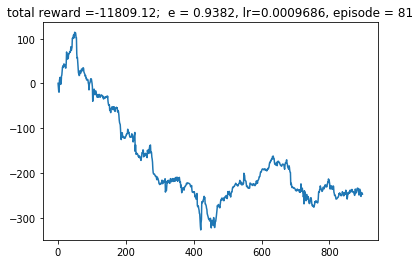

Waiting to train the whole dataset
action0:  592 
action1:  765 
action2:  623
DONE, lets roll!!
81.153


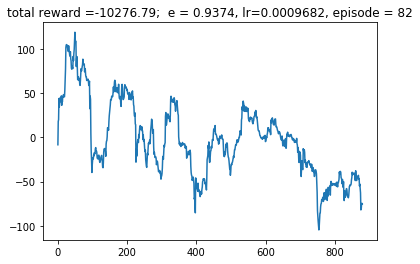

Waiting to train the whole dataset
action0:  605 
action1:  639 
action2:  736
DONE, lets roll!!
82.566


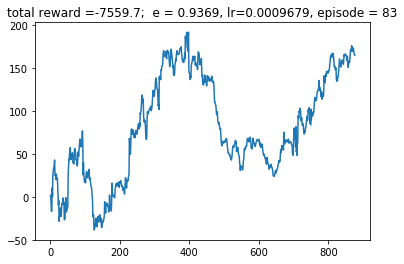

Waiting to train the whole dataset
action0:  606 
action1:  737 
action2:  637
DONE, lets roll!!
84.0


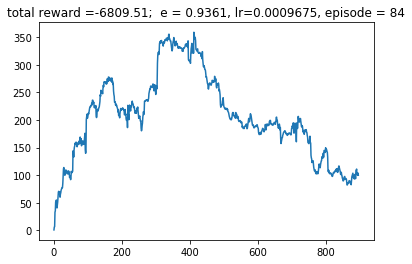

Waiting to train the whole dataset
action0:  590 
action1:  770 
action2:  620
DONE, lets roll!!
85.266


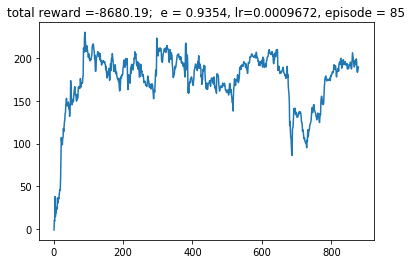

Waiting to train the whole dataset
action0:  616 
action1:  743 
action2:  621
DONE, lets roll!!
86.18


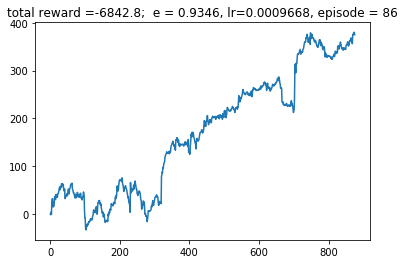

Waiting to train the whole dataset
action0:  639 
action1:  749 
action2:  592
DONE, lets roll!!
81.329


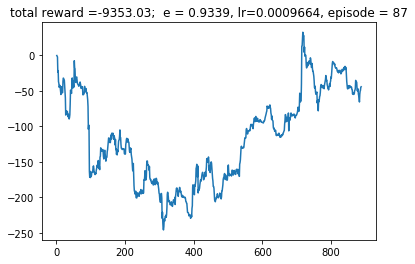

Waiting to train the whole dataset
action0:  593 
action1:  624 
action2:  763
DONE, lets roll!!
82.612


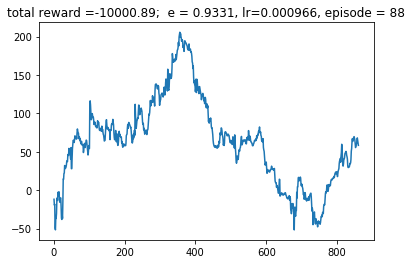

Waiting to train the whole dataset
action0:  635 
action1:  605 
action2:  740
DONE, lets roll!!
75.883


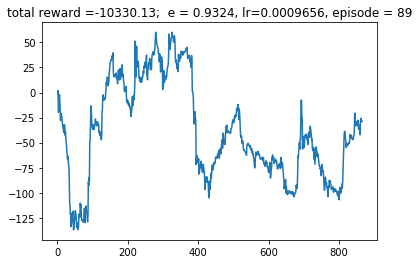

Waiting to train the whole dataset
action0:  584 
action1:  647 
action2:  749
DONE, lets roll!!
77.225


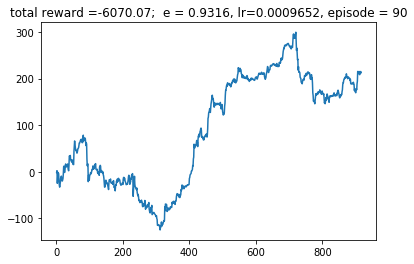

Waiting to train the whole dataset
action0:  591 
action1:  766 
action2:  623
DONE, lets roll!!
85.21


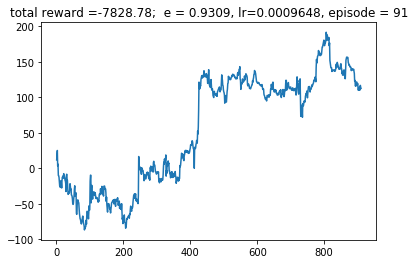

Waiting to train the whole dataset
action0:  613 
action1:  625 
action2:  742
DONE, lets roll!!
75.745


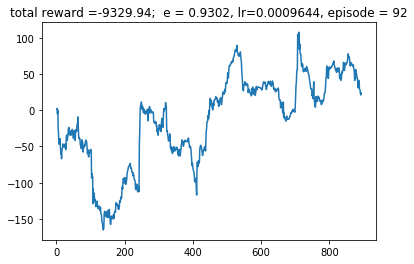

Waiting to train the whole dataset
action0:  595 
action1:  780 
action2:  605
DONE, lets roll!!
76.676


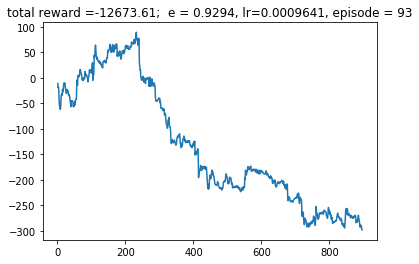

Waiting to train the whole dataset
action0:  621 
action1:  629 
action2:  730
DONE, lets roll!!
77.517


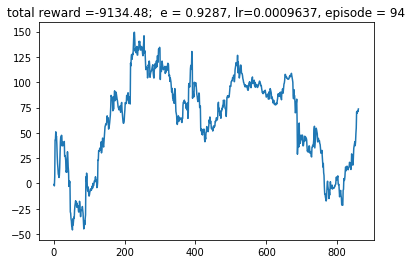

Waiting to train the whole dataset
action0:  618 
action1:  609 
action2:  753
DONE, lets roll!!
86.314


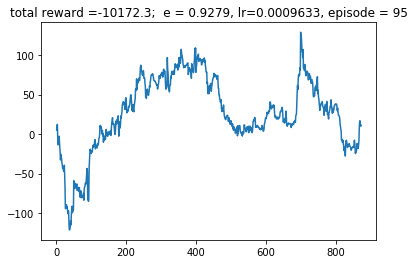

Waiting to train the whole dataset
action0:  638 
action1:  735 
action2:  607
DONE, lets roll!!
94.283


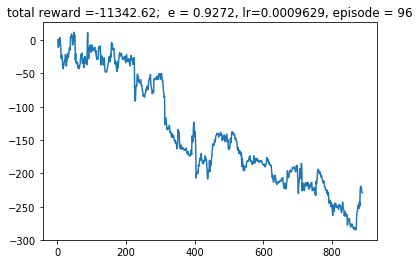

Waiting to train the whole dataset
action0:  587 
action1:  617 
action2:  776
DONE, lets roll!!
88.34


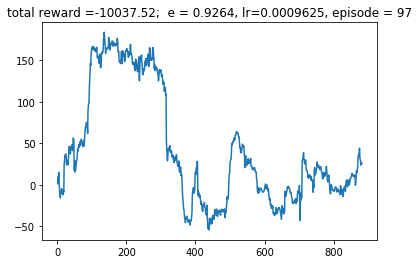

Waiting to train the whole dataset
action0:  625 
action1:  759 
action2:  596
DONE, lets roll!!
87.487


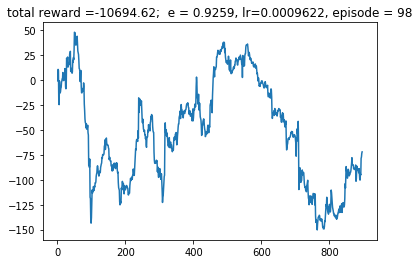

Waiting to train the whole dataset
action0:  627 
action1:  735 
action2:  618
DONE, lets roll!!
85.75


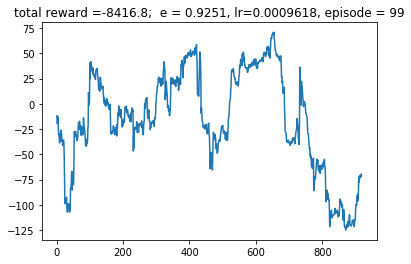

Waiting to train the whole dataset
action0:  574 
action1:  627 
action2:  779
DONE, lets roll!!
93.702


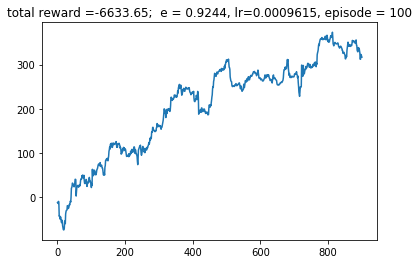

Waiting to train the whole dataset
action0:  613 
action1:  602 
action2:  765
DONE, lets roll!!
82.451


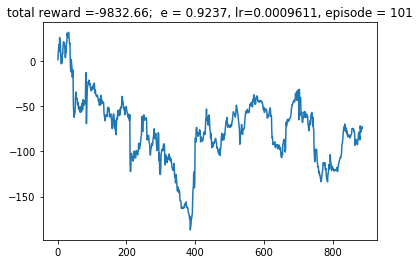

Waiting to train the whole dataset
action0:  609 
action1:  603 
action2:  768
DONE, lets roll!!
86.985


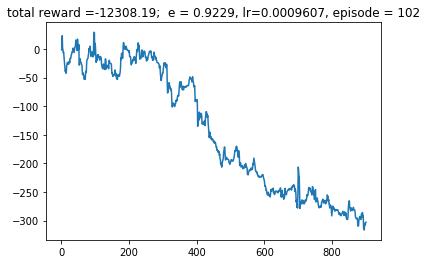

Waiting to train the whole dataset
action0:  599 
action1:  632 
action2:  749
DONE, lets roll!!
86.682


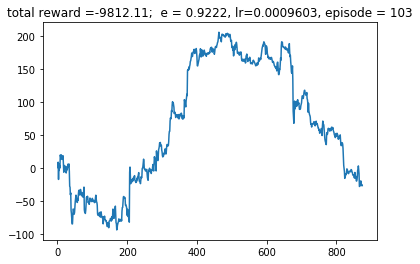

Waiting to train the whole dataset
action0:  607 
action1:  745 
action2:  628
DONE, lets roll!!
93.138


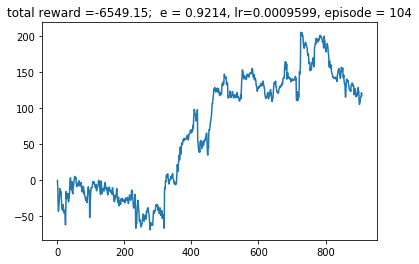

Waiting to train the whole dataset
action0:  551 
action1:  623 
action2:  806
DONE, lets roll!!
93.176


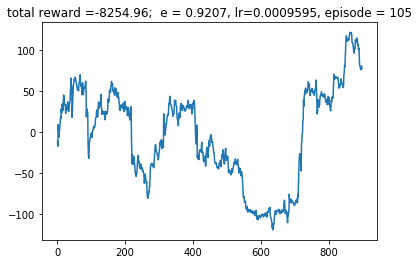

Waiting to train the whole dataset
action0:  580 
action1:  771 
action2:  629
DONE, lets roll!!
90.83


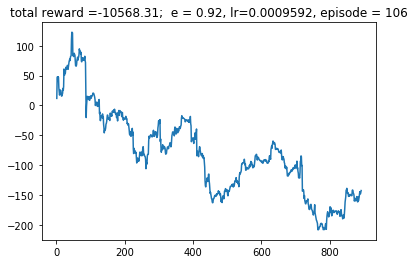

Waiting to train the whole dataset
action0:  616 
action1:  755 
action2:  609
DONE, lets roll!!
80.516


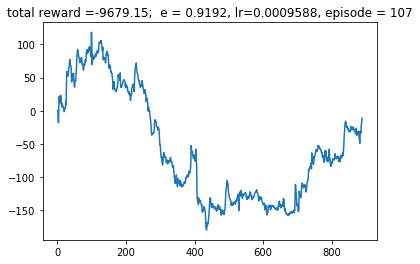

Waiting to train the whole dataset
action0:  594 
action1:  631 
action2:  755


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))